In [ ]:
使用网格搜索法对5个模型进行调优（调参时采用五折交叉验证的方式），并进行模型评估，记得展示代码的运行结果b

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#导入处理后的数据，4754*81
data = pd.read_csv('data/data_81col.csv')

In [22]:
# 生成训练集和测试集
from sklearn.model_selection import train_test_split
y = data['status']
X = data.drop(['status'],axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2018)

In [27]:
print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([2493,  834]))


In [55]:
#导入相关算法
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#导入模型评估分数
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import time

In [111]:
model_list = [('dt',DecisionTreeClassifier(random_state=2018,class_weight='balanced')),
              ('rf',RandomForestClassifier(random_state=2018,class_weight='balanced',n_jobs=2)),
              ('xgb',XGBClassifier(random_state=2018,n_jobs=2))]
score_list = [('准确率',accuracy_score),('精准率',precision_score),('召回率',recall_score),('F1_score',f1_score)]

#存储所有得分
result_dict = {}
df_total = pd.DataFrame()
params ={
        'dt':{'criterion':['gini','entropy'],'max_depth':[5,10,15]},
        'rf':{'n_estimators':[20,50,100,150],'criterion':['gini','entropy'],'max_depth':[5,10,15]},
        'xgb':{'learing_rate':[0.01,0.1,1],'max_depth':[5,10,15],'n_estimators':[20,50,100,150]}
        }
for model_name,model in model_list:
    start = time.time()
    clf = GridSearchCV(model,param_grid=params[model_name],cv=5,scoring='roc_auc')
    clf.fit(X_train,y_train)
    print('Model {}  best parameter:{}'.format(model_name,clf.best_params_))
    print('Model {}  best score:{}'.format(model_name,clf.best_score_))
    best_model = clf.best_estimator_
    y_train_predict = best_model.predict(X_train)
    y_test_predict = best_model.predict(X_test)
    
    result_dict[model_name] = {}
    result_dict[model_name]['Train'] = []
    result_dict[model_name]['Test'] = []
    #accuracy_score precison_score  recall_score f1_score
    for score_name,score in score_list: 
        result_dict[model_name]['Train'].append(score(y_train,y_train_predict))
        result_dict[model_name]['Test'].append(score(y_test,y_test_predict))
        
    #roc_auc_score  roc_curve
    
    result_dict[model_name]['Train'].append(roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]))
    result_dict[model_name]['Train'].append(roc_curve(y_train,best_model.predict_proba(X_train)[:,1]))
    result_dict[model_name]['Test'].append(roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]))
    result_dict[model_name]['Test'].append(roc_curve(y_test,best_model.predict_proba(X_test)[:,1]))
    
    df = pd.DataFrame({'Train':result_dict[model_name]['Train'][:-1],
                       'Test':result_dict[model_name]['Test'][:-1]
                      })    
    df = df.T
    df.set_index([[model_name,model_name],['Train','Test']],inplace=True)
    
    df_total = pd.concat([df_total,df])
    end = time.time()
    print('{} 所花时间为：{}'.format(model_name,end-start))
    

Model dt  best parameter:{'criterion': 'entropy', 'max_depth': 5}
Model dt  best score:0.7213517829449839
dt 所花时间为：2.184547185897827
Model rf  best parameter:{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
Model rf  best score:0.7952488727326831
rf 所花时间为：59.4072151184082
Model xgb  best parameter:{'learing_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Model xgb  best score:0.7944643135524245
xgb 所花时间为：340.53707003593445


In [71]:
#特征标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#GridSearchCV  逻辑回归 和 SVM  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [116]:
#逻辑回归
start = time.time()
lg = LogisticRegression(random_state=2018,class_weight='balanced',n_jobs=2)
params = {'C':[0.1,1,10],'max_iter':[50,100,150],'solver':['liblinear','lbfgs']}
clf = GridSearchCV(lg,param_grid=params,scoring='roc_auc')
clf.fit(X_train_scaled,y_train)
print('Model {}  best parameter:{}'.format(model_name,clf.best_params_))
print('Model {}  best score:{}'.format(model_name,clf.best_score_))
best_model = clf.best_estimator_
y_train_predict = best_model.predict(X_train_scaled)
y_test_predict = best_model.predict(X_test_scaled)

result_dict['lg'] = {}
result_dict['lg']['Train'] = []
result_dict['lg']['Test'] = []
for score_name,score in score_list: 
    result_dict['lg']['Train'].append(score(y_train,y_train_predict))
    result_dict['lg']['Test'].append(score(y_test,y_test_predict))

#roc_auc_score  roc_curve

result_dict['lg']['Train'].append(roc_auc_score(y_train,best_model.predict_proba(X_train_scaled)[:,1]))
result_dict['lg']['Train'].append(roc_curve(y_train,best_model.predict_proba(X_train_scaled)[:,1]))
result_dict['lg']['Test'].append(roc_auc_score(y_test,best_model.predict_proba(X_test_scaled)[:,1]))
result_dict['lg']['Test'].append(roc_curve(y_test,best_model.predict_proba(X_test_scaled)[:,1]))

df = pd.DataFrame({'Train':result_dict['lg']['Train'][:-1],
                   'Test':result_dict['lg']['Test'][:-1]
                  })    
df = df.T
df.set_index([['lg','lg'],['Train','Test']],inplace=True)

df_total = pd.concat([df_total,df])
end = time.time()
print('lg 所花时间为：{}'.format(end-start))


Model xgb  best parameter:{'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}
Model xgb  best score:0.7858233268980483
lg 所花时间为：5.3679070472717285


In [118]:
#svm
start = time.time()
svc = SVC(random_state=2018,class_weight='balanced',probability=True)
params = {'C':[0.1,1,10],'kernel':['rbf','linear']}
clf = GridSearchCV(svc,param_grid=params,scoring='roc_auc')
clf.fit(X_train_scaled,y_train)
print('Model {}  best parameter:{}'.format(model_name,clf.best_params_))
print('Model {}  best score:{}'.format(model_name,clf.best_score_))
best_model = clf.best_estimator_
y_train_predict = best_model.predict(X_train_scaled)
y_test_predict = best_model.predict(X_test_scaled)

result_dict['svc'] = {}
result_dict['svc']['Train'] = []
result_dict['svc']['Test'] = []
for score_name,score in score_list: 
    result_dict['svc']['Train'].append(score(y_train,y_train_predict))
    result_dict['svc']['Test'].append(score(y_test,y_test_predict))

#roc_auc_score  roc_curve

result_dict['svc']['Train'].append(roc_auc_score(y_train,best_model.predict_proba(X_train_scaled)[:,1]))
result_dict['svc']['Train'].append(roc_curve(y_train,best_model.predict_proba(X_train_scaled)[:,1]))
result_dict['svc']['Test'].append(roc_auc_score(y_test,best_model.predict_proba(X_test_scaled)[:,1]))
result_dict['svc']['Test'].append(roc_curve(y_test,best_model.predict_proba(X_test_scaled)[:,1]))

df = pd.DataFrame({'Train':result_dict['svc']['Train'][:-1],
                   'Test':result_dict['svc']['Test'][:-1]
                  })    
df = df.T
df.set_index([['svc','svc'],['Train','Test']],inplace=True)

df_total = pd.concat([df_total,df])
end = time.time()
print('svc 所花时间为：{}'.format(end-start))


Model xgb  best parameter:{'C': 1, 'kernel': 'linear'}
Model xgb  best score:0.782902919541623
svc 所花时间为：154.20784831047058


In [119]:
display(df_total)

0         1         2         3         4
dt  Train  0.756237  0.510044  0.700240  0.590197  0.814673
    Test   0.688157  0.414343  0.579387  0.483159  0.704562
rf  Train  0.805230  0.589768  0.732614  0.653476  0.873313
    Test   0.729502  0.471338  0.618384  0.534940  0.773653
xgb Train  0.901713  0.951872  0.640288  0.765591  0.968369
    Test   0.782761  0.623116  0.345404  0.444444  0.758260
lg  Train  0.762248  0.519043  0.702638  0.597045  0.821226
    Test   0.711282  0.447732  0.632312  0.524249  0.768993
svc Train  0.764052  0.521360  0.717026  0.603735  0.820399
    Test   0.709180  0.444000  0.618384  0.516880  0.762746

In [120]:
df_final = df_total.rename(columns=(dict(zip(np.arange(0,5),['准确率','精准率','召回率','F1-score','Auc-socre']))))
display(df_final)

准确率       精准率       召回率  F1-score  Auc-socre
dt  Train  0.756237  0.510044  0.700240  0.590197   0.814673
    Test   0.688157  0.414343  0.579387  0.483159   0.704562
rf  Train  0.805230  0.589768  0.732614  0.653476   0.873313
    Test   0.729502  0.471338  0.618384  0.534940   0.773653
xgb Train  0.901713  0.951872  0.640288  0.765591   0.968369
    Test   0.782761  0.623116  0.345404  0.444444   0.758260
lg  Train  0.762248  0.519043  0.702638  0.597045   0.821226
    Test   0.711282  0.447732  0.632312  0.524249   0.768993
svc Train  0.764052  0.521360  0.717026  0.603735   0.820399
    Test   0.709180  0.444000  0.618384  0.516880   0.762746

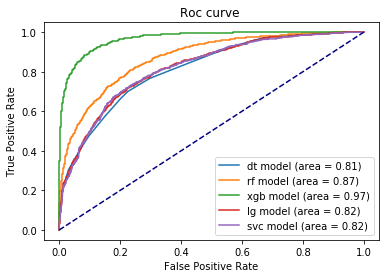

In [121]:
#训练集的 ROC 图
plt.figure()
for k in result_dict.keys():
    fpr,tpr,_ = result_dict[k]['Train'][-1]
    plt.plot(fpr,tpr,label='{} model (area = {:.2f})'.format(k,result_dict[k]['Train'][-2]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve ')
plt.show()

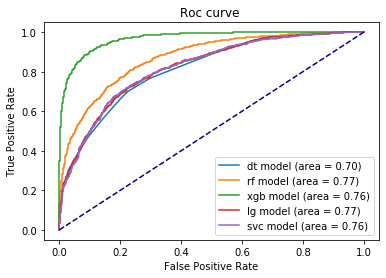

In [122]:
#测试集的 ROC 图
plt.figure()
for k in result_dict.keys():
    fpr,tpr,_ = result_dict[k]['Train'][-1]
    plt.plot(fpr,tpr,label='{} model (area = {:.2f})'.format(k,result_dict[k]['Test'][-2]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve ')
plt.show()

In [126]:
#怀疑 XGB 过拟合，再做一次网络搜索,从上次的参数再往下调,learing_rate max_depth都是最低的，所以再往低調；n_estimatorts是中间的值，所以不再调整
params ={
        'learing_rate':[0.001,0.01],'max_depth':[2,3,5]
        }

start = time.time()
clf = GridSearchCV(XGBClassifier(random_state=2018,n_jobs=2,n_estimators=50),param_grid=params,cv=5,scoring='roc_auc')
clf.fit(X_train,y_train)
print('Model {}  best parameter:{}'.format('xgb',clf.best_params_))
print('Model {}  best score:{}'.format('xgb',clf.best_score_))
best_model = clf.best_estimator_
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

for score_name,score in score_list: 
    print('train {}'.format(score_name),score(y_train,y_train_predict))
    print('test {} '.format(score_name),score(y_test,y_test_predict))

#roc_auc_score  roc_curve

print('train auc ',roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]))
print('test auc',roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]))



Model xgb  best parameter:{'learing_rate': 0.001, 'max_depth': 3}
Model xgb  best score:0.7996483569509336
train 准确率 0.8313796212804329
test 准确率  0.7932725998598459
train 精准率 0.819672131147541
test 精准率  0.6684210526315789
train 召回率 0.4196642685851319
test 召回率  0.35376044568245124
train F1_score 0.5551149881046787
test F1_score  0.4626593806921675
train auc  0.8772245741313086
test auc 0.7731904583059477


In [127]:
#显示之前 XGB 的分数
print(df_final.loc['xgb'])

            准确率       精准率       召回率  F1-score  Auc-socre
Train  0.901713  0.951872  0.640288  0.765591   0.968369
Test   0.782761  0.623116  0.345404  0.444444   0.758260


In [130]:
#对比可以出 best_score分数从0.7944提升到了0.7996，训练集上的其它分数都有提升，继续调参，这次只调 learning_rate
params ={
        'learing_rate':[0.0001,0.0003,0.0005]
        }

start = time.time()
clf = GridSearchCV(XGBClassifier(random_state=2018,n_jobs=2,n_estimators=50,max_depth=3),param_grid=params,cv=10,scoring='roc_auc')
clf.fit(X_train,y_train)
print('Model {}  best parameter:{}'.format('xgb',clf.best_params_))
print('Model {}  best score:{}'.format('xgb',clf.best_score_))
best_model = clf.best_estimator_
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

for score_name,score in score_list: 
    print('train {}'.format(score_name),score(y_train,y_train_predict))
    print('test {} '.format(score_name),score(y_test,y_test_predict))

#roc_auc_score  roc_curve

print('train auc ',roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]))
print('test auc',roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]))
end = time.time()
print('所花时间为：{}'.format(end-start))


Model xgb  best parameter:{'learing_rate': 0.0001}
Model xgb  best score:0.8014016983387195
train 准确率 0.8313796212804329
test 准确率  0.7932725998598459
train 精准率 0.819672131147541
test 精准率  0.6684210526315789
train 召回率 0.4196642685851319
test 召回率  0.35376044568245124
train F1_score 0.5551149881046787
test F1_score  0.4626593806921675
train auc  0.8772245741313086
test auc 0.7731904583059477
所花时间为：15.491289854049683


In [ ]:

调参完毕